In [1]:
"""Implementation of Newton-Cotes's and Gauss interpolation quadratures,
complex quadratures(CQFs) based on the aforementioned formulas, their
methodological errors estimation and logging.
"""

# WARNING: TRAILING UNDERSCORES EXPERIMENT TAKES PLACE HERE.
# Trailing underscores indicate that a variable is a container with
# homogeneous data of it's names objects.
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

In [2]:
# Defaults for N13
A_CONST = 1.5
B_CONST = 2.3
ALPHA = 1/5
BETA = 0

EPSILON = 1e-6

def f(x):
    """Smooth part of the integrated function."""
    return  2 * np.cos(3.5 * x) * np.exp(5 * x / 3)\
          + 3 * np.sin(1.5 * x) * np.exp(-4 * x) + 3


def p(x):
    """Weight part of the integrated function."""
    return 1 / ((x - A_CONST)**ALPHA * (B_CONST - x)**BETA)

def F(x):
    """Integrated function."""
    return f(x) * p(x)

# 32.2195145288426, absolute error <= 1.8413714997222996e-10
J = sp.integrate.quad(lambda x: F(x), A_CONST, B_CONST)[0]

In [3]:
class Quad:
    """Quadrature calculation with methods for error estimation and
    logging.

    Olemskoi-targeted implementation of the Newton-Cotes, Gauss IQFs and
    CQFs. Given a list of formulas, collects lists of the computations
    results that can be used further for building all necessary plots.

    Attributes:
        type__:
            type of qudrature formula to use.
        lbound:
            left bound of the integrated function's domain.
        rbound:
            right bound of the integrated  function's domain.
        nqf_:
            array of IQF's number to use in CQF at each iteration.
        nnodes_:
            array of nodes number to use in IQFs at each iteration.
        mesh_:
            array of nodes meshes that was used at each iteration.
        value_:
            array of quadrature sums that was obtained at each
            iteration.
        conv_rate_:
            array of convergence rates calculated with eitken rule at
            each iteration.
        abs_err_:
            array of absolute errors of quadrature sums calculated at
            each iteration.
        est_err_:
            array of error estimations at each iteration.
        
        opt_nqf:
            number of optimal IQF to use in a given CQF to achieve a
            desired precision.
    """

    def __init__(self, type__, lbound=A_CONST, rbound=B_CONST):
        """Initialize a quadrature of one of the available types.
        
        Args:
            type__: 'riemann', 'newton_cotes' or 'gauss' - type of a QF
                that will be applied to calculations of a quad. sum.
        """
        if type__ not in ['riemann', 'newton-cotes', 'gauss']:
            raise ValueError('Unknown quadrature type')
        self.type__ = type__
        self.lbound = lbound
        self.rbound = rbound

        # Computation journal            length:
        self.nqf_ = np.array([])        # n
        self.nnodes_ = np.array([])     # n
        self.mesh_ = np.array([])       # n
        self.value_ = np.array([])      # n
        self.conv_rate_ = np.array([])  # n-2
        self.abs_err_ = np.array([])    # n 
        self.est_err_ = np.array([])    # n-2
        self.qcoeffs_ = np.array([])
        self.opt_nqf = 0

    def __repr__(self):
        """Return string representation of the journaled properties."""
        return f"nqf = {self.nqf_}\nnnodes_ = {self.nnodes_}\nmesh_ = {self.mesh_}\nvalue_ = {self.value_}\nconv_rate_ = {self.conv_rate_}\nabs_err_ = {self.abs_err_}\nest_err_ = {self.est_err_}\nopt_nqf = {self.opt_nqf}"
    
    # Is intended for internal usage only
    def _quadrature(self, nnodes, lbound, rbound):
        """Calculate an IQF at the given range."""
        A_ = []
        match self.type__:
            case 'riemann': # Riemann quadrature:
                h = (rbound-lbound)/nnodes
                node_ = np.linspace(lbound, rbound, nnodes)
                quad = sum(h * F(lbound + h/2 + h*i) for i in range(nnodes))
            case 'newton-cotes': # Newton-Cotes interpolating quadrature:
                # 1. Set up node mesh;
                node_ = np.linspace(lbound, rbound, nnodes)
                # 2. Calculate moments of the weight function;
                mu_ = np.array([sp.integrate.quad(lambda x: p(x) * x**j, lbound, rbound)[0] for j in range(nnodes)])
                # 3. Solve SLE for the quadrature's coeffs;
                x_ = np.array([[node_[j]**s for j in range(nnodes)] for s in range(nnodes)])
                A_ = sp.linalg.solve(x_, mu_)
                # Quadrature sum.
                quad = sum(A_ * f(node_))
            case 'gauss': # Gauss interpolating quadrature:
                # 1. Calculate moments of the weight function;
                mu_ = np.array([sp.integrate.quad(lambda x: p(x) * x**j, lbound, rbound)[0] for j in range(2 * nnodes)])
                # 2. Solve SLE for nodal polynomial's coeffs;
                tmp_mu_ = np.array([[mu_[j+s] for j in range(nnodes)] for s in range(nnodes)])
                a_ = sp.linalg.solve(tmp_mu_, -mu_[nnodes:])
                # 3. Find nodes that are the nodal polynomial's roots
                w_ = np.concatenate(([1], a_[::-1]))
                node_ = np.roots(w_)
                # 4. Solve SLE for the quadrature's coeffs;
                if min(node_) < self.lbound or max(node_) > self.rbound:
                    print(f"Gauss nodal polynomial's roots are outside of the integration area for nnodes={nnodes}")
                x_ = np.array([[node_[j]**s for j in range(nnodes)] for s in range(nnodes)])
                A_ = sp.linalg.solve(x_, mu_[:nnodes])
                # Quadrature sum.
                quad = sum(A_ * f(node_))
        return (quad, node_, sum([np.abs(el) for el in A_]))
    
    # Is intended for internal usage only.
    def _cqf(self, nqf, nnodes):
        """Calcuclate a CQF using a given recipe.
        
        Compound quadrature formula (CQF) sum is obtained by dividing
        the function's domain into [nqf] subranges and summarizeing IQF
        with [nnodes] nodes that are calculated on each subrange.
        """
        # bounds of the quadratures involved
        mesh_ = np.linspace(self.lbound, self.rbound, nqf+1)
        # Quadrature sum
        quad = sum(self._quadrature(nnodes, mesh_[i-1], mesh_[i])[0] for i in range(1, nqf+1))
        return quad
   
   # Is intended for internal usage only.
    def _aitken(self, id):
        """Estimate a convergence rate for a [id]'th qudrature sum
        in a computations journal.
        """
        # Estimation is based on information about current one and two
        # following quad. values in computation journal.
        S_ = np.array([self.value_[id + i] for i in range(3)])
        h_ = np.array([(self.rbound - self.lbound) / self.nqf_[id + i] for i in range(3)])
        # Step multiplier varies. An average value is used instead
        L = (h_[0]/h_[1] + h_[1]/h_[2]) / 2
        # Formula (36)
        m = -np.log(np.abs((S_[2] - S_[1]) / (S_[1] - S_[0]))) / np.log(L)
        return (m, L)
    
    # Is intended for internal usage only.
    def _optimal_nqf(self):
        """Calculate a number of optimal quadratures to use in CQF to
        immediately acheive the desired precision.
        """
        m, L = self._aitken(0)
        h = (self.rbound - self.lbound) / self.nqf_[0]
        S_ = np.array([self.value_[i] for i in range(2)])
        # Formula (34)
        opt_h = h * (EPSILON * (1 - L**(-m)) / np.abs(S_[1] - S_[0]))**(1 / m)
        opt_nqf = np.ceil((self.rbound - self.lbound) / opt_h)
        return opt_nqf

    # Is intended for internal usage only.
    def _err(self, id):
        """Return absolute error of the given quadrature sum."""
        return np.abs(self.value_[id] - J)
    
    # Is intended for internal usage only.
    # CURRENTLY IS NOT WORKING - problems with (n+1) derivative
    # calculation. May be implemented with symbolic calculations but no>:(
    def _iqf_err_estim(self, id):
        """"Estimate a methodological error of an IQF from computation
        journal using formula (11).
        """
        mesh_ = self.mesh_[id]
        # Calculate nodal polynomial
        w = lambda x: np.prod(x - mesh_)
        # n + 1 points for n'th forward difference
        x_ = np.linspace(self.lbound, self.rbound, len(mesh_) + 1)
        M = np.abs(np.diff(f(x_), len(mesh_)))
        # formula (11)
        R = M / sp.special.factorial(len(mesh_)) * sp.integrate.quad(lambda x: np.abs(p(x) * w(x)),self.lbound, self.rbound)[0]
        return R
    
    # Is intended for internal usage only.
    def _cqf_err_estim(self, id, r=2):
        """Estimate a methodological error of a CQF from computation
        journal using Richardson's method.
        """
        m = self._aitken(id)[0]
        h_ = np.array([(self.rbound - self.lbound) / self.nqf_[id + i] for i in range(r + 1)])
        S_ = np.array([self.value_[id + i] for i in range(r + 1)])
        C_ = np.array([[-h_[i]**(m + j - 1) if j > 0 else 1 for j in range(r + 1)] for i in range(r + 1)])
        J_ = sp.linalg.solve(C_, S_)
        R = np.abs(J_[0] - S_[0])
        return R

    # The only public method
    def compute(self, nqf_, nnodes_):
        """Compute quadrature sum several times using given parameters.
        
        Mainly supposed to collect data for plotting information about
        quadratures precision and convergence rate upon variating
        parameters. The result of the calculations is stored in the
        journal attributes and must be accessed through them.
        
        Args:
            nqf_:
                array of IQF's number to use in CQF at each iteration.
            nnodes_:
                array of nodes number to use in IQFs at each iteration.

        Returns:
            none
        """
        n = len(nqf_)
        if len(nnodes_) != n:
            raise ValueError("Parameters' lengths aren't equal")
        self.nqf_ = np.array(nqf_)
        self.nnodes_ = np.array(nnodes_)
        if np.max(nqf_) == 1: # IQFs are calculated
            data_ = [self._quadrature(nnodes_[i], self.lbound, self.rbound) for i in range(n)]
            self.value_ = np.array([d_[0] for d_ in data_])
            self.mesh_ = np.array([d_[1] for d_ in data_])
            self.qcoeffs_ = np.array([d_[2] for d_ in data_])
            self.conv_rate_ = np.array([])
            self.abs_err_ = np.array([self._err(i) for i in range(n)])
            #self.est_err_ = np.array([self.iqf_err_estim(i) for i in range(n)])
        else: # CQFs are calculated
            data_ = [self._cqf(nqf_[i], nnodes_[i]) for i in range(n)]
            self.value_ = np.array(data_)
            self.abs_err_ = np.array([self._err(i) for i in range(n)])
            if n < 3:
                print('Convergence rate, method. error and optimal step estimations are not available because n is lower than 3.')
            else:
                self.conv_rate_ = np.array([self._aitken(i)[0] for i in range(n - 2)])
                self.est_err_ = np.array([self._cqf_err_estim(i) for i in range(n-2)])
                self.opt_nqf = self._optimal_nqf()

/tmp/ipykernel_3245/1706863183.py:207: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.mesh_ = np.array([d_[1] for d_ in data_])


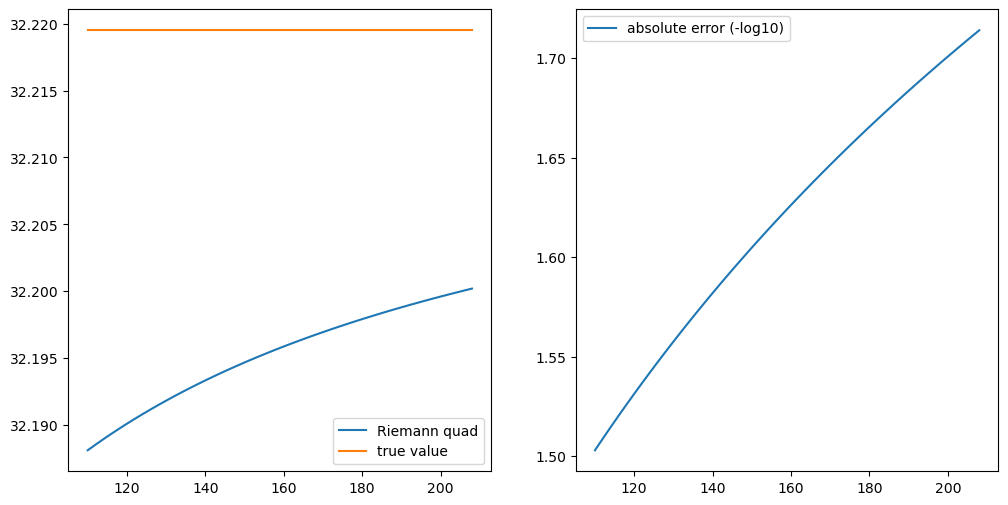

In [4]:
riemann = Quad('riemann')
riemann.compute(np.ones(50), np.arange(110,210,2))
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
ax1.plot(riemann.nnodes_, riemann.value_, label='Riemann quad')
ax1.plot(riemann.nnodes_, np.array([J for i in range(50)]), label='true value')
ax1.legend()
ax2.plot(riemann.nnodes_, -np.log10(riemann.abs_err_), label='absolute error (-log10)')
ax2.legend()

/tmp/ipykernel_3245/1706863183.py:83: LinAlgWarning: Ill-conditioned matrix (rcond=1.2699e-17): result may not be accurate.
  A_ = sp.linalg.solve(x_, mu_)
/tmp/ipykernel_3245/1706863183.py:83: LinAlgWarning: Ill-conditioned matrix (rcond=8.5084e-20): result may not be accurate.
  A_ = sp.linalg.solve(x_, mu_)
/tmp/ipykernel_3245/1706863183.py:83: LinAlgWarning: Ill-conditioned matrix (rcond=1.23624e-19): result may not be accurate.
  A_ = sp.linalg.solve(x_, mu_)
/tmp/ipykernel_3245/1706863183.py:83: LinAlgWarning: Ill-conditioned matrix (rcond=5.9477e-20): result may not be accurate.
  A_ = sp.linalg.solve(x_, mu_)
/tmp/ipykernel_3245/1706863183.py:83: LinAlgWarning: Ill-conditioned matrix (rcond=8.8692e-21): result may not be accurate.
  A_ = sp.linalg.solve(x_, mu_)
/tmp/ipykernel_3245/1706863183.py:207: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated

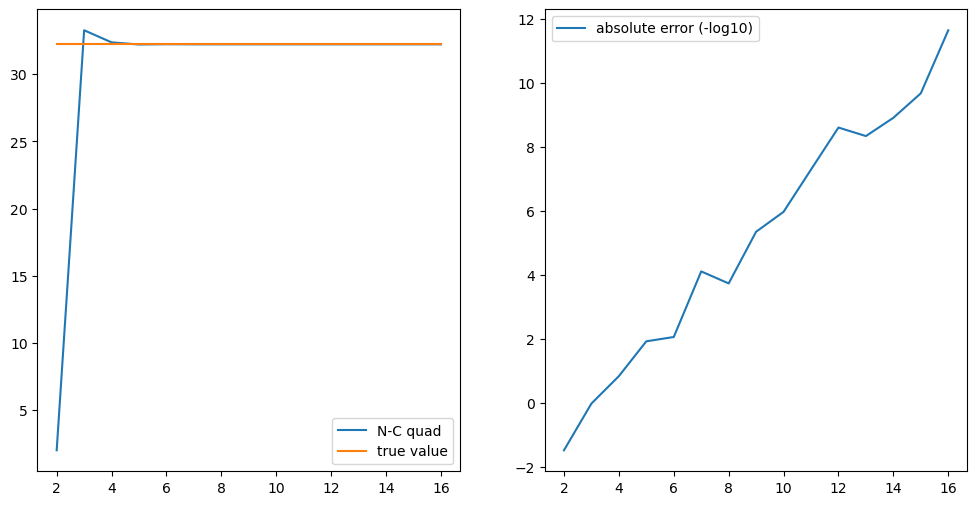

In [5]:
newton_cotes = Quad('newton-cotes')
newton_cotes.compute(np.ones(15), np.arange(2,17))
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
ax1.plot(newton_cotes.nnodes_, newton_cotes.value_, label='N-C quad')
ax1.plot(newton_cotes.nnodes_, np.array([J for i in range(15)]), label='true value')
ax1.legend()
ax2.plot(newton_cotes.nnodes_, -np.log10(newton_cotes.abs_err_), label='absolute error (-log10)')
ax2.legend()

Gauss nodal polynomial's roots are outside of the integration area for nnodes=7
Gauss nodal polynomial's roots are outside of the integration area for nnodes=8
Gauss nodal polynomial's roots are outside of the integration area for nnodes=9
Gauss nodal polynomial's roots are outside of the integration area for nnodes=10


/tmp/ipykernel_3245/1706863183.py:91: LinAlgWarning: Ill-conditioned matrix (rcond=8.67768e-18): result may not be accurate.
  a_ = sp.linalg.solve(tmp_mu_, -mu_[nnodes:])
/tmp/ipykernel_3245/1706863183.py:91: LinAlgWarning: Ill-conditioned matrix (rcond=1.35151e-18): result may not be accurate.
  a_ = sp.linalg.solve(tmp_mu_, -mu_[nnodes:])
/tmp/ipykernel_3245/1706863183.py:91: LinAlgWarning: Ill-conditioned matrix (rcond=4.4092e-20): result may not be accurate.
  a_ = sp.linalg.solve(tmp_mu_, -mu_[nnodes:])
/tmp/ipykernel_3245/1706863183.py:99: LinAlgWarning: Ill-conditioned matrix (rcond=2.47421e-18): result may not be accurate.
  A_ = sp.linalg.solve(x_, mu_[:nnodes])
/tmp/ipykernel_3245/1706863183.py:91: LinAlgWarning: Ill-conditioned matrix (rcond=8.98193e-20): result may not be accurate.
  a_ = sp.linalg.solve(tmp_mu_, -mu_[nnodes:])
/tmp/ipykernel_3245/1706863183.py:207: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lis

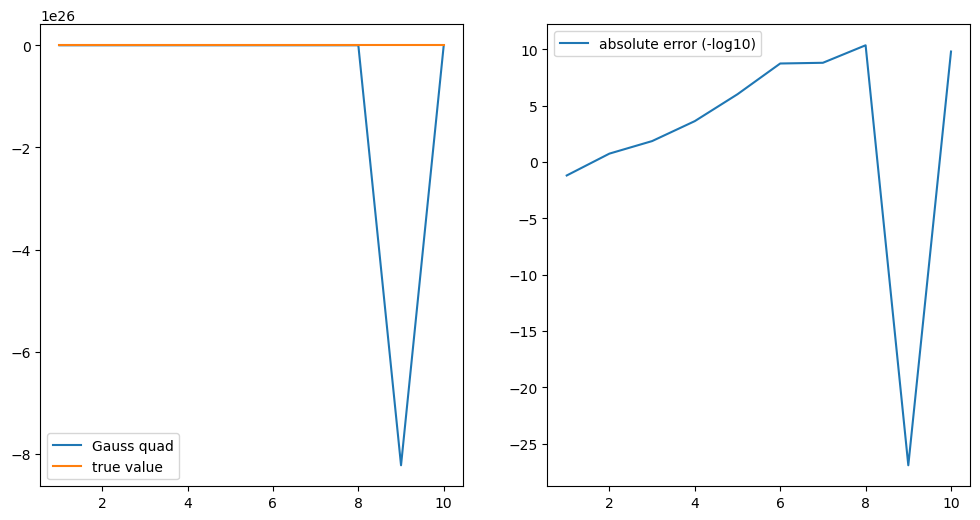

In [6]:
gauss = Quad('gauss')
gauss.compute(np.ones(10), np.arange(1,11))
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
ax1.plot(gauss.nnodes_, gauss.value_, label='Gauss quad')
ax1.plot(gauss.nnodes_, np.array([J for i in range(10)]), label='true value')
ax1.legend()
ax2.plot(gauss.nnodes_, -np.log10(gauss.abs_err_), label='absolute error (-log10)')
ax2.legend()

/tmp/ipykernel_3245/1706863183.py:83: LinAlgWarning: Ill-conditioned matrix (rcond=1.2699e-17): result may not be accurate.
  A_ = sp.linalg.solve(x_, mu_)
/tmp/ipykernel_3245/1706863183.py:83: LinAlgWarning: Ill-conditioned matrix (rcond=8.5084e-20): result may not be accurate.
  A_ = sp.linalg.solve(x_, mu_)
/tmp/ipykernel_3245/1706863183.py:83: LinAlgWarning: Ill-conditioned matrix (rcond=1.23624e-19): result may not be accurate.
  A_ = sp.linalg.solve(x_, mu_)
/tmp/ipykernel_3245/1706863183.py:83: LinAlgWarning: Ill-conditioned matrix (rcond=5.9477e-20): result may not be accurate.
  A_ = sp.linalg.solve(x_, mu_)
/tmp/ipykernel_3245/1706863183.py:83: LinAlgWarning: Ill-conditioned matrix (rcond=8.8692e-21): result may not be accurate.
  A_ = sp.linalg.solve(x_, mu_)
/tmp/ipykernel_3245/1706863183.py:83: LinAlgWarning: Ill-conditioned matrix (rcond=1.11853e-21): result may not be accurate.
  A_ = sp.linalg.solve(x_, mu_)
/tmp/ipykernel_3245/1706863183.py:83: LinAlgWarning: Ill-condi

Gauss nodal polynomial's roots are outside of the integration area for nnodes=25
Gauss nodal polynomial's roots are outside of the integration area for nnodes=26
Gauss nodal polynomial's roots are outside of the integration area for nnodes=27
Gauss nodal polynomial's roots are outside of the integration area for nnodes=28
Gauss nodal polynomial's roots are outside of the integration area for nnodes=29
Gauss nodal polynomial's roots are outside of the integration area for nnodes=30
Gauss nodal polynomial's roots are outside of the integration area for nnodes=31
Gauss nodal polynomial's roots are outside of the integration area for nnodes=32
Gauss nodal polynomial's roots are outside of the integration area for nnodes=33


/tmp/ipykernel_3245/1706863183.py:91: LinAlgWarning: Ill-conditioned matrix (rcond=3.64836e-28): result may not be accurate.
  a_ = sp.linalg.solve(tmp_mu_, -mu_[nnodes:])


Gauss nodal polynomial's roots are outside of the integration area for nnodes=34


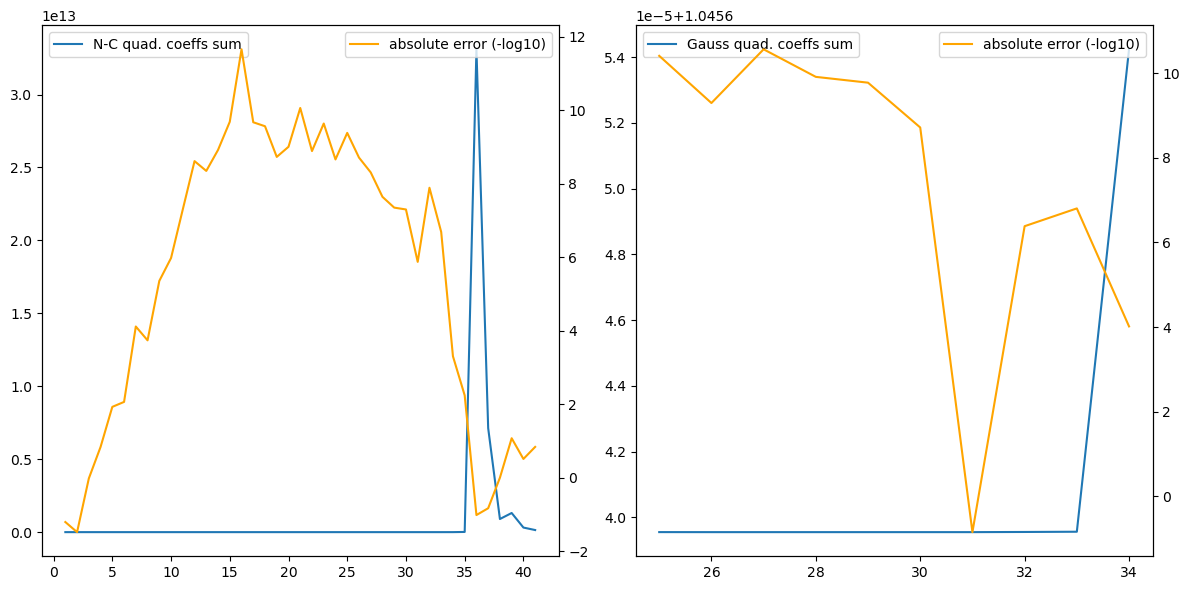

In [7]:
newton_cotes = Quad('newton-cotes')
newton_cotes.compute(np.ones(41), np.arange(1,42))
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
ax1.plot(newton_cotes.nnodes_, newton_cotes.qcoeffs_, label='N-C quad. coeffs sum')
ax1.legend()
ax11 = ax1.twinx()
ax11.plot(newton_cotes.nnodes_, -np.log10(newton_cotes.abs_err_), color='orange', label='absolute error (-log10)')
ax11.legend()

gauss = Quad('gauss')
gauss.compute(np.ones(10), np.arange(25,35))
ax2.plot(gauss.nnodes_, gauss.qcoeffs_, label='Gauss quad. coeffs sum')
ax2.legend()
ax22 = ax2.twinx()
ax22.plot(gauss.nnodes_, -np.log10(gauss.abs_err_), color='orange', label='absolute error (-log10)')
ax22.legend()

fig.tight_layout()


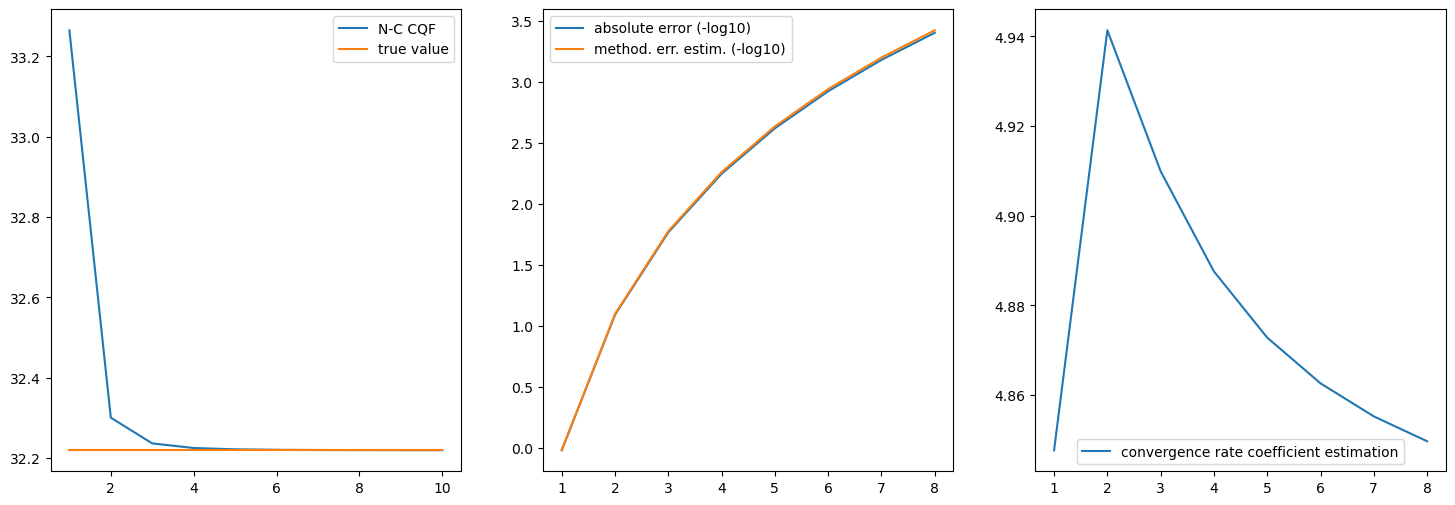

In [8]:
newton_cotes_cqf = Quad('newton-cotes')
newton_cotes_cqf.compute(np.arange(1,11), np.array([3 for i in range(10)]))
nc_opt = newton_cotes_cqf.opt_nqf
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,6))
ax1.plot(newton_cotes_cqf.nqf_, newton_cotes_cqf.value_, label='N-C CQF')
ax1.plot(newton_cotes_cqf.nqf_, np.array([J for i in range(10)]), label='true value')
ax1.legend()
ax2.plot(newton_cotes_cqf.nqf_[:-2], -np.log10(newton_cotes_cqf.abs_err_[:-2]), label='absolute error (-log10)')
ax2.plot(newton_cotes_cqf.nqf_[:-2], -np.log10(newton_cotes_cqf.est_err_), label='method. err. estim. (-log10)')
ax2.legend()
ax3.plot(newton_cotes_cqf.nqf_[:-2], newton_cotes_cqf.conv_rate_, label='convergence rate coefficient estimation')
ax3.legend()

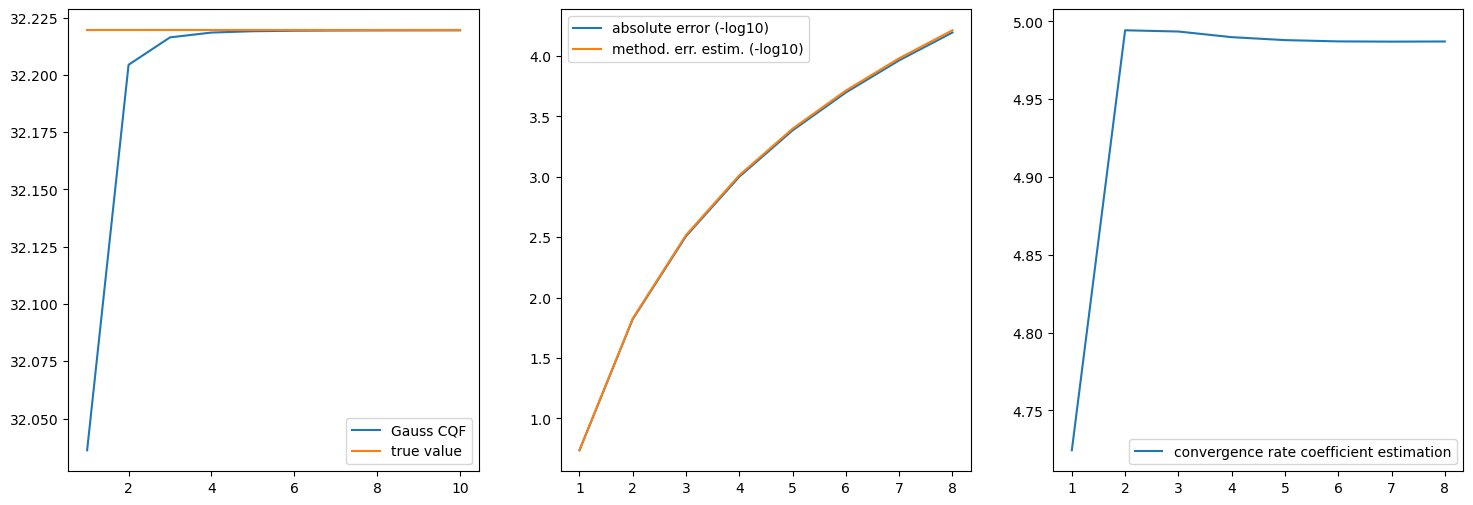

In [9]:
gauss_cqf = Quad('gauss')
gauss_cqf.compute(np.arange(1,11), np.array([2 for i in range(10)]))
g_opt = gauss_cqf.opt_nqf
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,6))
ax1.plot(gauss_cqf.nqf_, gauss_cqf.value_, label='Gauss CQF')
ax1.plot(gauss_cqf.nqf_, np.array([J for i in range(10)]), label='true value')
ax1.legend()
ax2.plot(gauss_cqf.nqf_[:-2], -np.log10(gauss_cqf.abs_err_[:-2]), label='absolute error (-log10)')
ax2.plot(gauss_cqf.nqf_[:-2], -np.log10(gauss_cqf.est_err_), label='method. err. estim. (-log10)')
ax2.legend()
ax3.plot(gauss_cqf.nqf_[:-2], gauss_cqf.conv_rate_, label='convergence rate coefficient estimation')
ax3.legend()

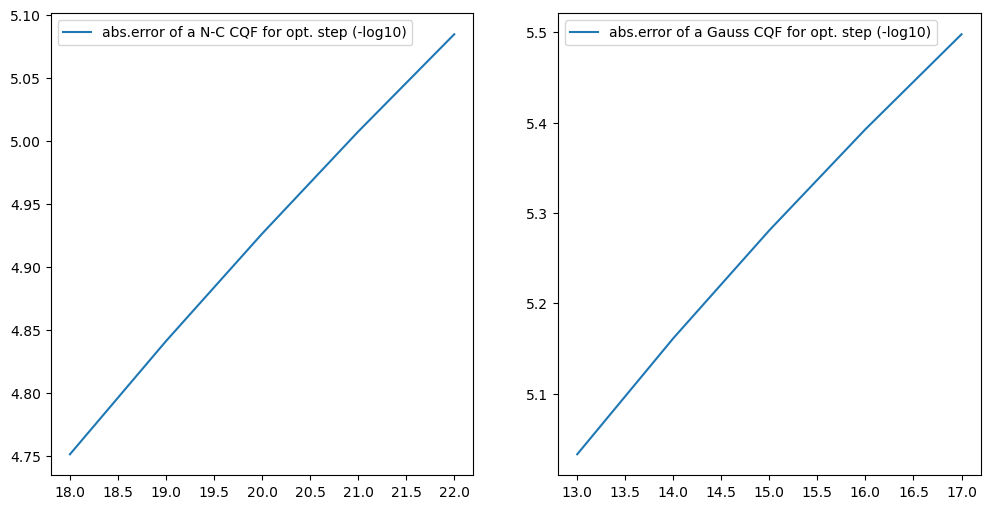

In [10]:
opt_newton_cotes_cqf = Quad('newton-cotes')
opt_newton_cotes_cqf.compute(np.arange(int(nc_opt), int(nc_opt)+5), np.array([3 for i in range(5)]))
opt_gauss_cqf = Quad('gauss')
opt_gauss_cqf.compute(np.arange(int(g_opt), int(g_opt)+5), np.array([2 for i in range(5)]))
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,6))
ax1.plot(opt_newton_cotes_cqf.nqf_, -np.log10(opt_newton_cotes_cqf.abs_err_), label='abs.error of a N-C CQF for opt. step (-log10)')
ax1.legend()
ax2.plot(opt_gauss_cqf.nqf_, -np.log10(opt_gauss_cqf.abs_err_), label='abs.error of a Gauss CQF for opt. step (-log10)')
ax2.legend()
